<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [403]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [404]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-01-17 01:21:46--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-01-17 01:21:47 (12.6 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [405]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [406]:
df.shape

(346, 10)

### Convert to date time object 

In [407]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [408]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [409]:
# INSTALL seaborn and pydotplus
#!conda install -c anaconda seaborn -y
#!conda install -c anaconda pydotplus -y

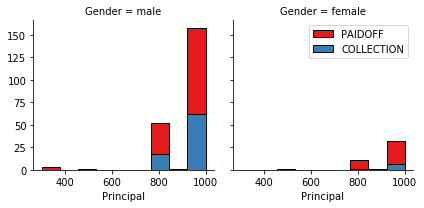

In [410]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

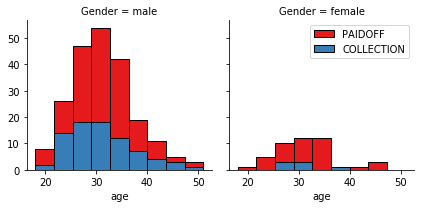

In [411]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

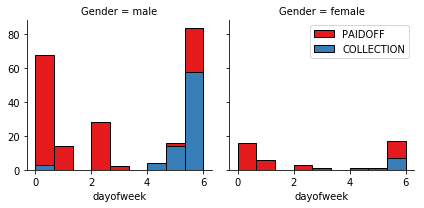

In [412]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [413]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [414]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [415]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [416]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [417]:
df[['Principal','terms','age','Gender','weekend','education']].head()

,Principal,terms,age,Gender,weekend,education
0,1000,30,45,0,0,High School or Below
1,1000,30,33,1,0,Bechalor
2,1000,15,27,0,0,college
3,1000,30,28,1,1,college
4,1000,30,29,0,1,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [418]:
#featurelabel = ['Principal','terms','age','Gender','weekend'] --- Good 
#featurelabel = ['terms','age','Gender','weekend'] --- Good 
#featurelabel = ['Principal','age','Gender','weekend'] --- BAD
#featurelabel = ['age','Gender','weekend'] --- Not Bad for simplicity
#featurelabel = ['terms','age','Gender','dayofweek','weekend'] - Not Bad
#featurelabel = ['Principal','terms','age','Gender','weekend'] - Good
#featurelabel = ['Principal','terms','age','Gender','dayofweek','weekend'] - Good
#featurelabel = ['terms','age','Gender','dayofweek','weekend'] - Best?
featurelabels = ['terms','age','Gender','dayofweek','weekend']
Feature = df[featurelabels]
Feature.head()
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
np.sum(Feature['Master or Above'])
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,terms,age,Gender,dayofweek,weekend,Bechalor,High School or Below,college
0,30,45,0,3,0,0,1,0
1,30,33,1,3,0,1,0,0
2,15,27,0,3,0,0,0,1
3,30,28,1,4,1,0,0,1
4,30,29,0,4,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [419]:
X = Feature
X[0:5]

,terms,age,Gender,dayofweek,weekend,Bechalor,High School or Below,college
0,30,45,0,3,0,0,1,0
1,30,33,1,3,0,1,0,0
2,15,27,0,3,0,0,0,1
3,30,28,1,4,1,0,0,1
4,30,29,0,4,1,0,0,1


What are our lables?

In [420]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [421]:
X = preprocessing.StandardScaler().fit(X).transform(X)
#X = preprocessing.MinMaxScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.92,  2.33, -0.42, -0.26, -1.21, -0.38,  1.14, -0.87],
       [ 0.92,  0.34,  2.38, -0.26, -1.21,  2.62, -0.88, -0.87],
       [-0.96, -0.65, -0.42, -0.26, -1.21, -0.38, -0.88,  1.15],
       [ 0.92, -0.49,  2.38,  0.12,  0.83, -0.38, -0.88,  1.15],
       [ 0.92, -0.32, -0.42,  0.12,  0.83, -0.38, -0.88,  1.15]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

In [422]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
# function for computing confusion matrix                                                                                                                                              
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """                                                                                                                                                         
    This function prints and plots the confusion matrix.                                                                                                        
    Normalization can be applied by setting `normalize=True`.                                                                                                   
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

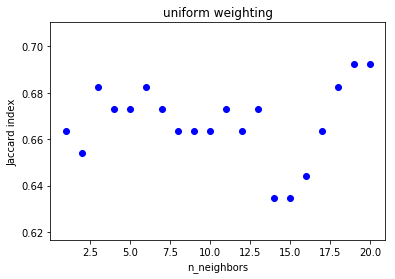

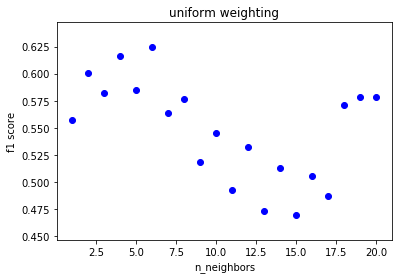

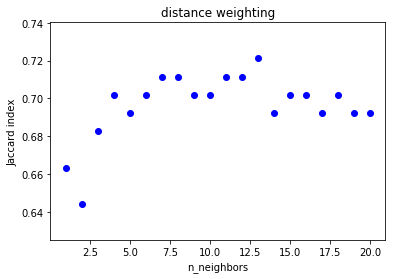

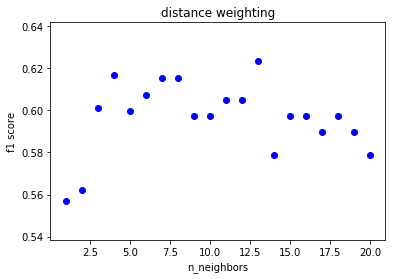

The best k-value is  13


In [423]:
# split test-set and training-set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
# build model, fit, predict
from sklearn.neighbors.classification import KNeighborsClassifier
from sklearn.metrics import jaccard_similarity_score, f1_score
kmax = 20
weights = ['uniform','distance']
for w in weights:
    jaccard = np.zeros(kmax)
    f1 = np.zeros(kmax)
    #y_pred = np.chararray((len(X_test),kmax),itemsize=12,unicode=True) # character array with len(elements) <= 12, suppress b'
    y_pred = np.ndarray((len(X_test),kmax), dtype="U13") # dtype unicode string length 13
    for i in range(kmax):
        knn = KNeighborsClassifier(n_neighbors=i+1, weights=w)
        knn.fit(X_train,y_train)
        y_pred[:,i] = knn.predict(X_test)
        #print(type(y_test),y_test.shape,y_test)
        #print(type(y_pred[:,i]),y_pred[:,i].shape,y_pred[:,i])
        jaccard[i] = jaccard_similarity_score(y_test, y_pred[:,i])
        # average of f1 of the two categories
        f1[i] = (f1_score(y_test, y_pred[:,i], pos_label='COLLECTION')+f1_score(y_test, y_pred[:,i], pos_label='PAIDOFF'))/2
    # plot error/accuracy analysis
    plt.scatter(range(1,kmax+1,1), jaccard,  color='blue')
    plt.title(w+' weighting')
    plt.xlabel("n_neighbors")
    plt.ylabel("Jaccard index")
    plt.show()
    plt.scatter(range(1,kmax+1,1), f1,  color='blue')
    plt.title(w+' weighting')
    plt.xlabel("n_neighbors")
    plt.ylabel("f1 score")
    plt.show()
    
# pick the k-value with the highest Jaccard+f1score (by distance weighting)
tot_accuracy = jaccard + f1
bestk = int(np.where(tot_accuracy == np.max(tot_accuracy))[0]) # the best k is where total accuracy is max
print('The best k-value is ',bestk+1)
y_hat = y_pred[:,bestk]

Model Accuracy :  0.7211538461538461
Jaccard index :  0.7211538461538461
f1 score :  0.6233295866117148
              precision    recall  f1-score   support

  COLLECTION       0.46      0.41      0.43        27
     PAIDOFF       0.80      0.83      0.82        77

   micro avg       0.72      0.72      0.72       104
   macro avg       0.63      0.62      0.62       104
weighted avg       0.71      0.72      0.72       104

Confusion matrix, without normalization
[[11 16]
 [13 64]]


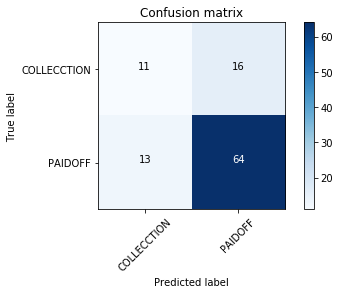

In [424]:
# Error/accuracy evaluation
from sklearn import metrics
import matplotlib.pyplot as plt
print("Model Accuracy : ", metrics.accuracy_score(y_test, y_hat))
# Jacaard index                                                                                                                                                                                                                   
from sklearn.metrics import jaccard_similarity_score
print('Jaccard index : ',jaccard_similarity_score(y_test, y_hat))
# f1 score                                                                                                                                                                                                                   
from sklearn.metrics import f1_score
print('f1 score : ',(f1_score(y_test, y_hat, pos_label='COLLECTION')+f1_score(y_test, y_hat, pos_label='PAIDOFF'))/2)
# compute confusion matrix                                                                                                                                      
cnf_matrix = confusion_matrix(y_test, y_hat)
np.set_printoptions(precision=2)
print (classification_report(y_test, y_hat))
# plot non-normalized confusion matrix                                                                                                                          
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECCTION','PAIDOFF'],normalize=False,  title='Confusion matrix')

# Decision Tree

In [426]:
# split test-set and training-set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
# build model, fit, predict
from sklearn.tree import DecisionTreeClassifier
mytree = DecisionTreeClassifier(criterion="entropy", max_depth = 5)
mytree # it shows the default parameters                                                                                                                      
mytree.fit(X_train,y_train)
y_pred = mytree.predict(X_test)

Model Accuracy:  0.6826923076923077
Jaccard index :  0.6826923076923077
f1 score :  0.582227632379793
              precision    recall  f1-score   support

  COLLECTION       0.38      0.37      0.38        27
     PAIDOFF       0.78      0.79      0.79        77

   micro avg       0.68      0.68      0.68       104
   macro avg       0.58      0.58      0.58       104
weighted avg       0.68      0.68      0.68       104

Confusion matrix, without normalization
[[10 17]
 [16 61]]


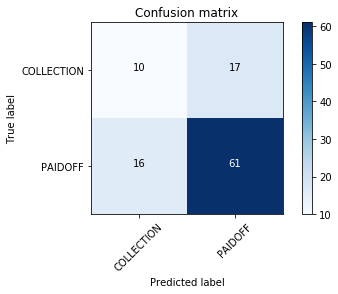

In [427]:
# error/accuracy evaluation
from sklearn import metrics
import matplotlib.pyplot as plt
print("Model Accuracy: ", metrics.accuracy_score(y_test, y_pred))
# Jacaard index                                                                                                                                                                                                                   
from sklearn.metrics import jaccard_similarity_score
print('Jaccard index : ',jaccard_similarity_score(y_test, y_pred))
# f1 score                                                                                                                                                                                                                   
from sklearn.metrics import f1_score
print('f1 score : ',(f1_score(y_test, y_pred, pos_label='COLLECTION')+f1_score(y_test, y_pred, pos_label='PAIDOFF'))/2)
# compute confusion matrix                                                                                                                                                                                                        
cnf_matrix = confusion_matrix(y_test, y_pred, labels=["COLLECTION","PAIDOFF"])
np.set_printoptions(precision=2)
print (classification_report(y_test, y_pred))
# plot non-normalized confusion matrix                                                                                                                                                                                            
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'],normalize= False,  title='Confusion matrix')

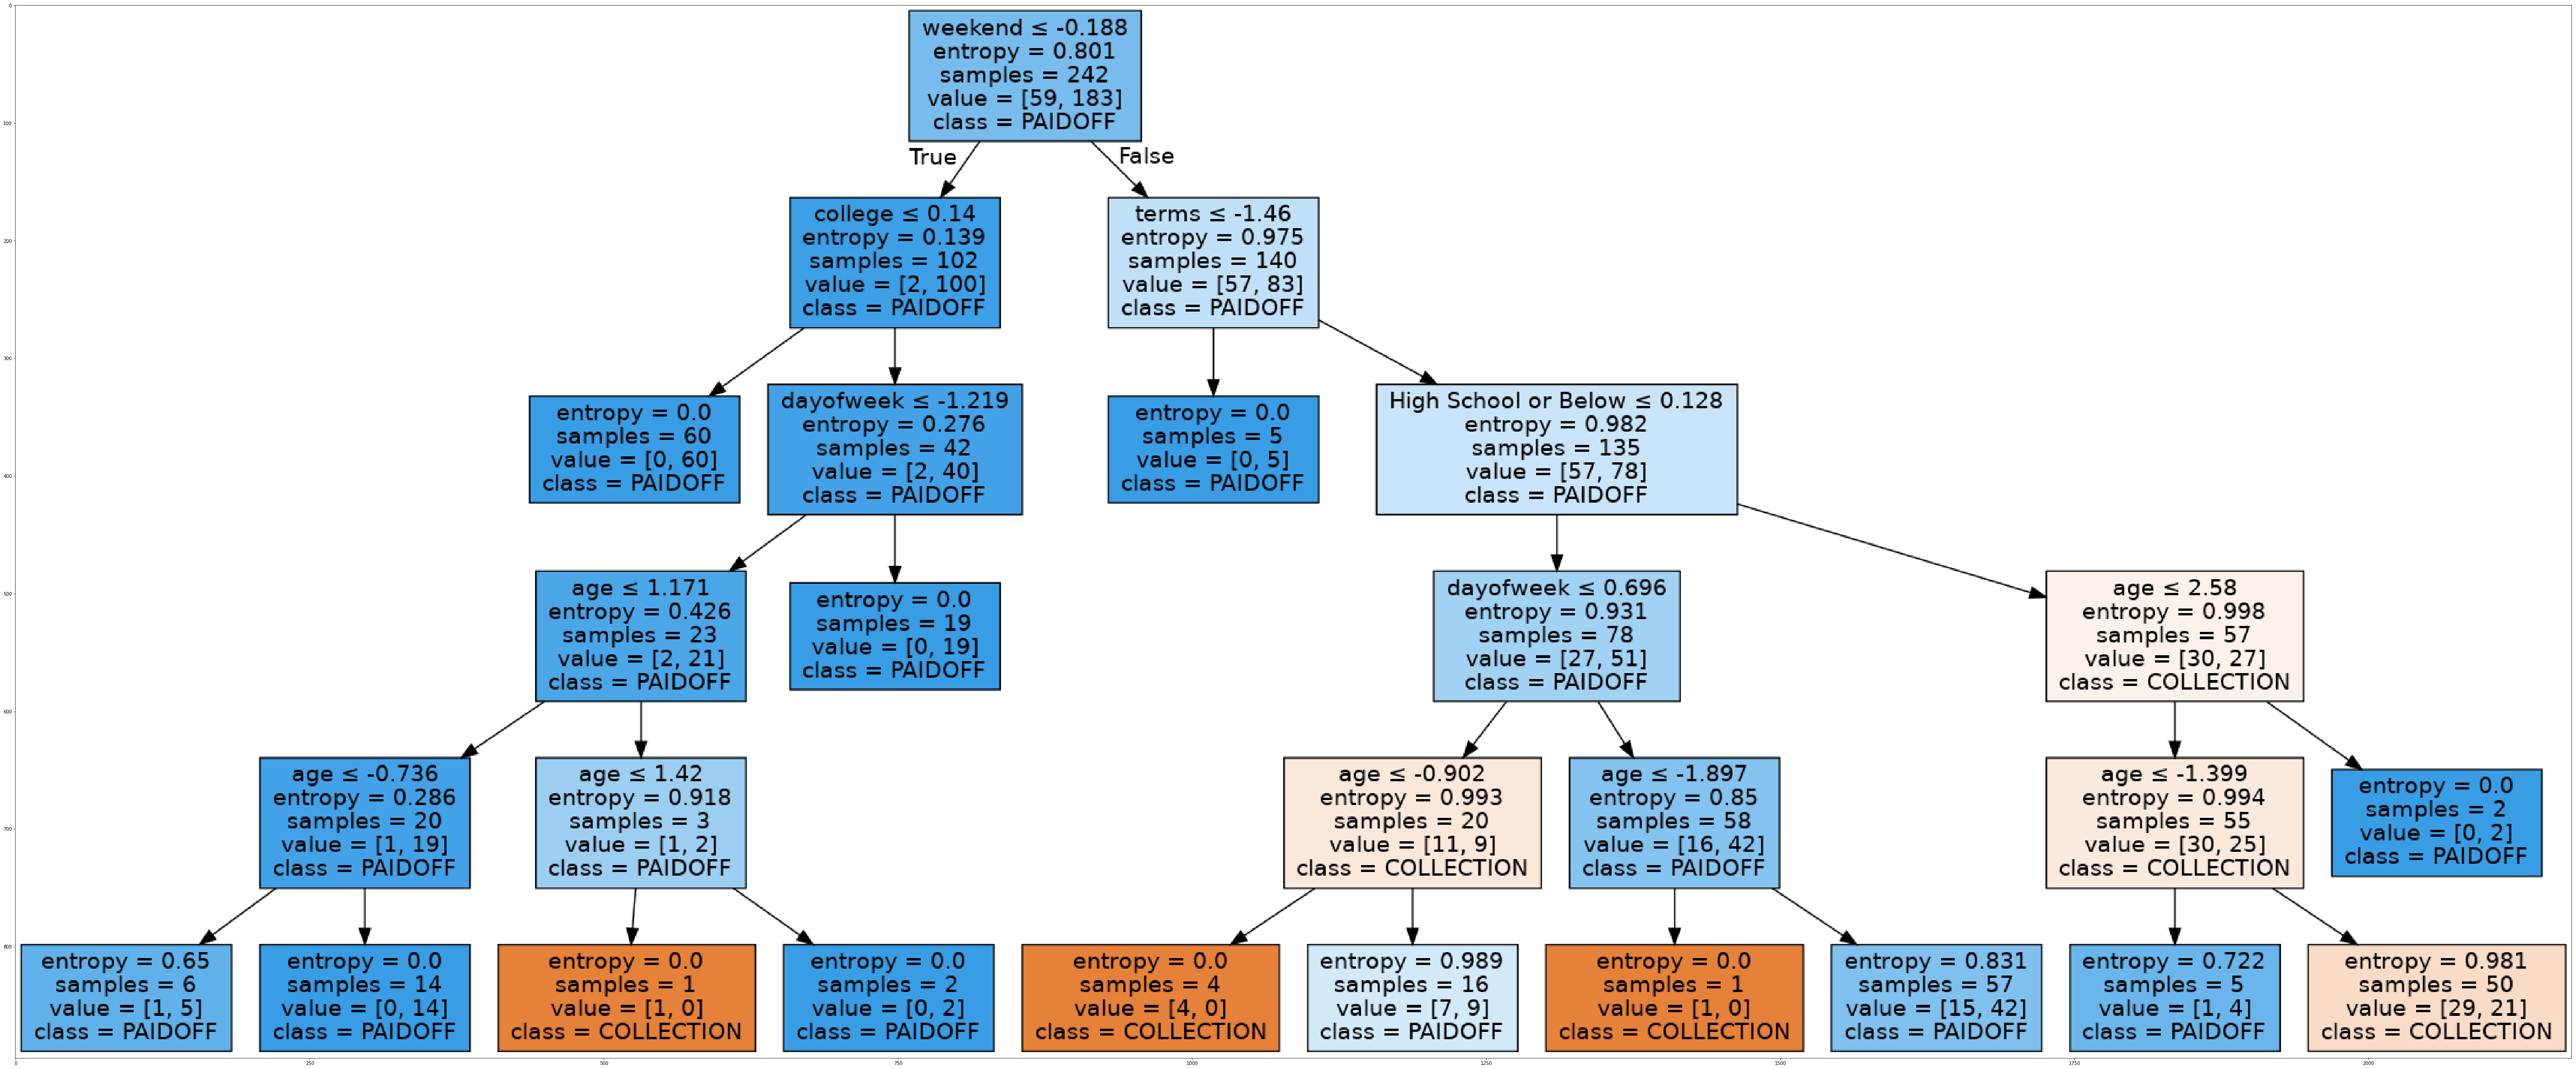

In [428]:
# visualize tree                   
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline
dot_data = StringIO()
filename = "tree.png"
#featureNames = Feature.columns[0:Feature.shape[1]]
featureNames = Feature.columns
targetNames = df["loan_status"].unique().tolist()
out=tree.export_graphviz(mytree, max_depth = 8,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')


# Support Vector Machine

In [429]:
# train-test split                                                                                                                                                                                              
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
from sklearn import svm
mysvm = svm.SVC(kernel='rbf',degree=5,gamma='scale',probability=True) # radial basis function is the kernel function to map dat onto higher dimensions                                                    
mysvm.fit(X_train, y_train)                                                                                                                                          
y_pred = mysvm.predict(X_test)
y_pred_prob = mysvm.predict_log_proba(X_test)

Model Accuracy:  0.7428571428571429
Jaccard index :  0.7428571428571429
f1 score :  0.5748987854251012
Log loss :  0.6931471805599454
              precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

   micro avg       0.74      0.74      0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70

Confusion matrix, without normalization
[[ 4 11]
 [ 7 48]]


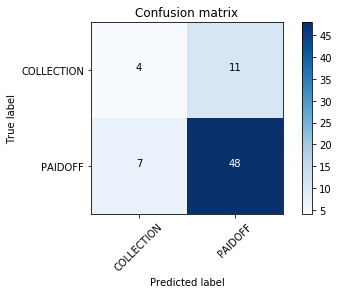

In [430]:
# Error/accuracy evaluation
from sklearn import metrics
import matplotlib.pyplot as plt
print("Model Accuracy: ", metrics.accuracy_score(y_test, y_pred))
# Jacaard index                                                                                                                                                                                                                   
from sklearn.metrics import jaccard_similarity_score
print('Jaccard index : ',jaccard_similarity_score(y_test, y_pred))
# f1 score                                                                                                                                                                                                                   
from sklearn.metrics import f1_score
print('f1 score : ',(f1_score(y_test, y_pred, pos_label='COLLECTION')+f1_score(y_test, y_pred, pos_label='PAIDOFF'))/2)
# log loss                                                                                                                                                                                                      
from sklearn.metrics import log_loss
print('Log loss : ',log_loss(y_test, y_pred_prob))
# compute confusion matrix                                                                                                                                                                                                        
cnf_matrix = confusion_matrix(y_test, y_pred, labels=["COLLECTION","PAIDOFF"])
np.set_printoptions(precision=2)
print (classification_report(y_test, y_pred))
# plot non-normalized confusion matrix                                                                                                                                                                                            
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'],normalize= False,  title='Confusion matrix')

# Logistic Regression

In [431]:
# train-test split                                                                                                                                                                                              
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)
# choose model and fit                                                                                                                                                                                          
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
y_pred = LR.predict(X_test)
y_pred_prob = LR.predict_proba(X_test)

Model Accuracy:  0.6442307692307693
Jaccard index :  0.6442307692307693
f1 score :  0.5427213309566251
Log loss :  0.5668896640578638
Confusion matrix, without normalization
[[ 9 18]
 [19 58]]
              precision    recall  f1-score   support

  COLLECTION       0.32      0.33      0.33        27
     PAIDOFF       0.76      0.75      0.76        77

   micro avg       0.64      0.64      0.64       104
   macro avg       0.54      0.54      0.54       104
weighted avg       0.65      0.64      0.65       104



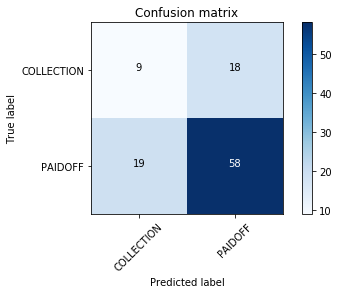

In [432]:
# Error/accuracy evaluation
from sklearn import metrics
import matplotlib.pyplot as plt
print("Model Accuracy: ", metrics.accuracy_score(y_test, y_pred))
# Jacaard index                                                                                                                                                                                                 
from sklearn.metrics import jaccard_similarity_score
print('Jaccard index : ',jaccard_similarity_score(y_test, y_pred))
# f1 score                                                                                                                                                                                                                   
from sklearn.metrics import f1_score
print('f1 score : ',(f1_score(y_test, y_pred, pos_label='COLLECTION')+f1_score(y_test, y_pred, pos_label='PAIDOFF'))/2)
# log loss                                                                                                                                                                                                      
from sklearn.metrics import log_loss
print('Log loss : ',log_loss(y_test, y_pred_prob))
# compute confusion matrix                                                                                                                                                                                      
cnf_matrix = confusion_matrix(y_test, y_pred, labels=['COLLECTION','PAIDOFF'])
np.set_printoptions(precision=2)
# plot non-normalized confusion matrix                                                                                                                                                                          
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'],normalize= False,  title='Confusion matrix')
print (classification_report(y_test, y_pred))


# Model Evaluation using Test set

In [433]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [434]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-01-17 01:22:04--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-01-17 01:22:04 (405 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load and clean test set for evaluation 

In [435]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()
print('Shape of the original data : ',test_df.shape)

# Convert dates to datetime object
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

# Get the day of week when people get loan
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), test_df.dayofweek.max(), 10)

# Binarization of weekend (1 if weekend, 0 if not) and Gender (1 if female, 0 if male)
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

# Take corresponding features to training
test_Feature = test_df[featurelabels]
print('Shape of the feature set : ',test_Feature.shape)
# One hot encoding to break up education
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
np.sum(test_Feature['Master or Above'])
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)
X_testset = test_Feature
y_testset = test_df['loan_status'].values

# Normalize dataset
X_testset = preprocessing.StandardScaler().fit(X_testset).transform(X_testset)

test_Feature.head()

Shape of the original data :  (54, 10)
Shape of the feature set :  (54, 5)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:28: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


,terms,age,Gender,dayofweek,weekend,Bechalor,High School or Below,college
0,30,50,1,3,0,1,0,0
1,7,35,0,4,1,0,0,0
2,30,43,1,5,1,0,1,0
3,30,26,0,5,1,0,0,1
4,15,29,0,6,1,1,0,0


# K-nearest neighbor

Model Accuracy:  0.7777777777777778
Jaccard index :  0.7777777777777778
f1 score :  0.6454033771106942
              precision    recall  f1-score   support

  COLLECTION       0.50      0.43      0.46        14
     PAIDOFF       0.81      0.85      0.83        40

   micro avg       0.74      0.74      0.74        54
   macro avg       0.65      0.64      0.65        54
weighted avg       0.73      0.74      0.73        54

Confusion matrix, without normalization
[[ 6  8]
 [ 6 34]]


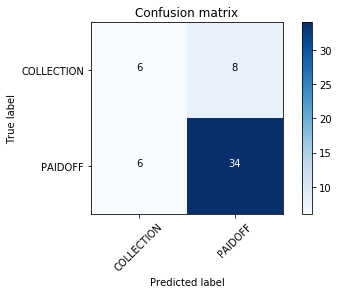

In [436]:
# Predict
y_pred_knn = knn.predict(X_testset)

# Error/accuracy evaluation
from sklearn import metrics
import matplotlib.pyplot as plt
modelacc_knn = metrics.accuracy_score(y_testset, y_pred_tree)
print("Model Accuracy: ", modelacc_knn)
# Jacaard index                                                                                                                                                                                                                   
from sklearn.metrics import jaccard_similarity_score
jaccard_knn = jaccard_similarity_score(y_testset, y_pred_tree)
print('Jaccard index : ', jaccard_knn)
# f1 score                                                                                                                                                                                                                   
from sklearn.metrics import f1_score
f1_knn = (f1_score(y_testset, y_pred_knn, pos_label='COLLECTION')+f1_score(y_testset, y_pred_knn, pos_label='PAIDOFF'))/2
print('f1 score : ',f1_knn)
# compute confusion matrix                                                                                                                                                                                                        
cnf_matrix = confusion_matrix(y_testset, y_pred_knn, labels=["COLLECTION","PAIDOFF"])
np.set_printoptions(precision=2)
print (classification_report(y_testset, y_pred_knn))
# plot non-normalized confusion matrix                                                                                                                                                                                            
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'],normalize= False,  title='Confusion matrix')

# Decision Tree

Model Accuracy:  0.7777777777777778
Jaccard index :  0.7777777777777778
f1 score :  0.7107142857142856
              precision    recall  f1-score   support

  COLLECTION       0.57      0.57      0.57        14
     PAIDOFF       0.85      0.85      0.85        40

   micro avg       0.78      0.78      0.78        54
   macro avg       0.71      0.71      0.71        54
weighted avg       0.78      0.78      0.78        54

Confusion matrix, without normalization
[[ 8  6]
 [ 6 34]]


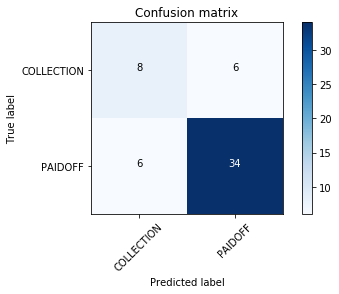

In [437]:
# Predict
y_pred_tree = mytree.predict(X_testset)

# Error/accuracy evaluation
from sklearn import metrics
import matplotlib.pyplot as plt
modelacc_tree = metrics.accuracy_score(y_testset, y_pred_tree)
print("Model Accuracy: ", modelacc_tree)
# Jacaard index                                                                                                                                                                                                                   
from sklearn.metrics import jaccard_similarity_score
jaccard_tree = jaccard_similarity_score(y_testset, y_pred_tree)
print('Jaccard index : ', jaccard_tree)
# f1 score                                                                                                                                                                                                                   
from sklearn.metrics import f1_score
f1_tree = (f1_score(y_testset, y_pred_tree, pos_label='COLLECTION')+f1_score(y_testset, y_pred_tree, pos_label='PAIDOFF'))/2
print('f1 score : ',f1_tree)
# compute confusion matrix                                                                                                                                                                                                        
cnf_matrix = confusion_matrix(y_testset, y_pred_tree, labels=["COLLECTION","PAIDOFF"])
np.set_printoptions(precision=2)
print (classification_report(y_testset, y_pred_tree))
# plot non-normalized confusion matrix                                                                                                                                                                                            
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'],normalize= False,  title='Confusion matrix')

# Support  Vector Machine

Model Accuracy:  0.7962962962962963
Jaccard index :  0.7962962962962963
f1 score :  0.6748768472906405
Log loss :  0.5126095435894779
              precision    recall  f1-score   support

  COLLECTION       0.71      0.36      0.48        14
     PAIDOFF       0.81      0.95      0.87        40

   micro avg       0.80      0.80      0.80        54
   macro avg       0.76      0.65      0.67        54
weighted avg       0.78      0.80      0.77        54

Confusion matrix, without normalization
[[ 5  9]
 [ 2 38]]


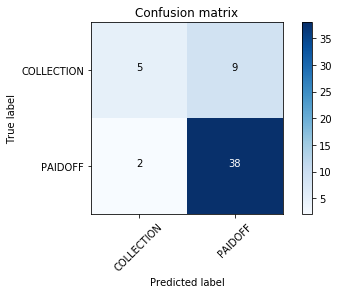

In [438]:
# Predict
y_pred_svm = mysvm.predict(X_testset)
y_pred_prob_svm = mysvm.predict_proba(X_testset)

# Error/accuracy evaluation
from sklearn import metrics
import matplotlib.pyplot as plt
modelacc_svm = metrics.accuracy_score(y_testset, y_pred_svm)
print("Model Accuracy: ", modelacc_svm)
# Jacaard index                                                                                                                                                                                                                   
from sklearn.metrics import jaccard_similarity_score
jaccard_svm = jaccard_similarity_score(y_testset, y_pred_svm)
print('Jaccard index : ', jaccard_svm)
# f1 score                                                                                                                                                                                                                   
from sklearn.metrics import f1_score
f1_svm = (f1_score(y_testset, y_pred_svm, pos_label='COLLECTION')+f1_score(y_testset, y_pred_svm, pos_label='PAIDOFF'))/2
print('f1 score : ',f1_svm)
# log loss                                                                                                                                                                                                      
from sklearn.metrics import log_loss
logloss_svm = log_loss(y_testset, y_pred_prob_svm)
print('Log loss : ', logloss_svm)
# compute confusion matrix                                                                                                                                                                                                        
cnf_matrix = confusion_matrix(y_testset, y_pred_svm, labels=["COLLECTION","PAIDOFF"])
np.set_printoptions(precision=2)
print (classification_report(y_testset, y_pred_svm))
# plot non-normalized confusion matrix                                                                                                                                                                                            
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'],normalize= False,  title='Confusion matrix')

# Logistic Regression

Model Accuracy:  0.6481481481481481
Jaccard index :  0.6481481481481481
f1 score :  0.47519181585677744
Log loss :  0.571218677824831
Confusion matrix, without normalization
[[ 2 12]
 [ 7 33]]
              precision    recall  f1-score   support

  COLLECTION       0.22      0.14      0.17        14
     PAIDOFF       0.73      0.82      0.78        40

   micro avg       0.65      0.65      0.65        54
   macro avg       0.48      0.48      0.48        54
weighted avg       0.60      0.65      0.62        54



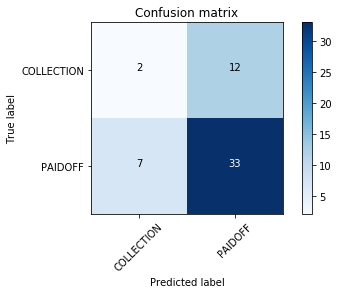

In [439]:
# Predict
y_pred_logreg = LR.predict(X_testset)
y_pred_prob_logreg = LR.predict_proba(X_testset)

# Error/accuracy evaluation
from sklearn import metrics
import matplotlib.pyplot as plt
modelacc_logreg = metrics.accuracy_score(y_testset, y_pred_logreg)
print("Model Accuracy: ", modelacc_logreg)
# Jacaard index                                                                                                                                                                                                 
from sklearn.metrics import jaccard_similarity_score
jaccard_logreg = jaccard_similarity_score(y_testset, y_pred_logreg)
print('Jaccard index : ',jaccard_logreg)
# f1 score                                                                                                                                                                                                                   
from sklearn.metrics import f1_score
f1_logreg = (f1_score(y_testset, y_pred_logreg, pos_label='COLLECTION')+f1_score(y_testset, y_pred_logreg, pos_label='PAIDOFF'))/2
print('f1 score : ',f1_logreg)
# log loss                                                                                                                                                                                                      
from sklearn.metrics import log_loss
logloss_logreg = log_loss(y_testset, y_pred_prob_logreg)
print('Log loss : ',logloss_logreg)
# compute confusion matrix                                                                                                                                                                                      
cnf_matrix = confusion_matrix(y_testset, y_pred_logreg, labels=['COLLECTION','PAIDOFF'])
np.set_printoptions(precision=2)
# plot non-normalized confusion matrix                                                                                                                                                                          
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'],normalize= False,  title='Confusion matrix')
print (classification_report(y_testset, y_pred_logreg))

In [440]:
print(np.round(jaccard_knn,5))
print(np.round(jaccard_tree,5))
print(np.round(jaccard_svm,5))
print(np.round(jaccard_logreg,5))
print('\n')
print(np.round(f1_knn,5))
print(np.round(f1_tree,5))
print(np.round(f1_svm,5))
print(np.round(f1_logreg,5))
print('\n')
print(np.round(logloss_logreg,5))

0.77778
0.77778
0.7963
0.64815


0.6454
0.71071
0.67488
0.47519


0.57122


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.77778 | 0.64540  | NA      |
| Decision Tree      | 0.77778 | 0.71071  | NA      |
| SVM                | 0.79630 | 0.67488  | NA      |
| LogisticRegression | 0.64815 | 0.47519  | 0.57122 |